In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import randint

from keras.datasets import cifar10

from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import TensorBoard

from keras import regularizers
from keras import backend as K


In [ ]:
#Autoencoder with single encoding and decoding layers
input_img = Input(shape=(3072,))
encoded = Dense(32, activation='relu')(input_img)
output_img = Dense(3072, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.datasets import cifar10
# Downloading dataset from internet
(x_train,y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
#Normalizing the values from 0 to 255 == 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255
#Reshaping the data into 2d
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [ ]:
# Fitting the data to autoencoder
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 31us/step - loss: 0.6930 - accuracy: 0.0062 - val_loss: 0.6928 - val_accuracy: 0.0065
Epoch 2/10
50000/50000 [==============================] - 2s 30us/step - loss: 0.6918 - accuracy: 0.0070 - val_loss: 0.6896 - val_accuracy: 0.0077
Epoch 3/10
50000/50000 [==============================] - 2s 30us/step - loss: 0.6849 - accuracy: 0.0085 - val_loss: 0.6799 - val_accuracy: 0.0090
Epoch 4/10
50000/50000 [==============================] - 2s 30us/step - loss: 0.6767 - accuracy: 0.0092 - val_loss: 0.6734 - val_accuracy: 0.0095
Epoch 5/10
50000/50000 [==============================] - 2s 30us/step - loss: 0.6696 - accuracy: 0.0098 - val_loss: 0.6653 - val_accuracy: 0.0102
Epoch 6/10
50000/50000 [==============================] - 1s 30us/step - loss: 0.6614 - accuracy: 0.0105 - val_loss: 0.6577 - val_accuracy: 0.0108
Epoch 7/10
50000/50000 [==============================] - 1s 29us/st

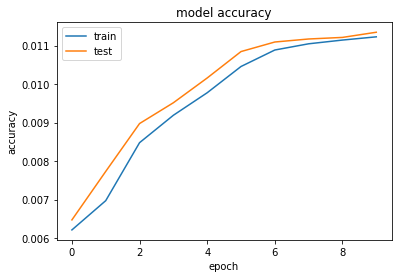

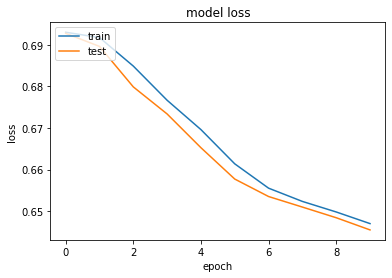

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Copying xtrain data and xtext data into new variables so as to use in the next step 
x_train1 = x_train
for k in range(0, 50000):
  prediction = autoencoder.predict(x_train[k].reshape(1,3072))
  x_train1[k] = prediction

x_test1 = x_test.copy()
for k in range(0, 10000):
  prediction = autoencoder.predict(x_test[k].reshape(1,3072))
  x_test1[k] = prediction

In [ ]:
x_train1 = np.array(x_train1).reshape([-1, 32, 32, 3]) 
x_test1 = np.array(x_test1).reshape([-1, 32, 32, 3]) 
print(x_train1.shape)
print(x_test1.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
#Preparing model for CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3), kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))



In [ ]:
# Compile model
epochs = 20
lrate = 0.01
decay = lrate/epochs
sgd = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=sgd, metrics=['accuracy'])
print(model.summary())


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 3)         9248      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 3)         9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 16, 1)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)             

In [ ]:
print(x_test1.shape)
print(x_train1.shape)
print(y_test.shape)
print(y_train.shape)

history1 = model.fit(x_train1, y_train, validation_data=(x_test1, y_test), epochs=epochs, batch_size=32)

(10000, 32, 32, 3)
(50000, 32, 32, 3)
(10000, 1)
(50000, 1)
Epoch 1/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1939 - accuracy: 0.2524 - val_loss: 2.1850 - val_accuracy: 0.2626
Epoch 2/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1862 - accuracy: 0.2617 - val_loss: 2.1755 - val_accuracy: 0.2737
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1808 - accuracy: 0.2667 - val_loss: 2.1769 - val_accuracy: 0.2710
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1805 - accuracy: 0.2678 - val_loss: 2.1750 - val_accuracy: 0.2730
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1773 - accuracy: 0.2694 - val_loss: 2.1732 - val_accuracy: 0.2756
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1769 - accuracy: 0.2718 - val_loss: 2.1740 - val_accuracy: 0.2738
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 

In [ ]:
scores = model.evaluate(x_test1, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 28.17%


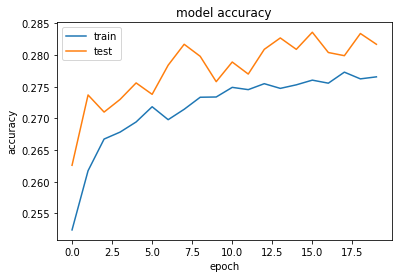

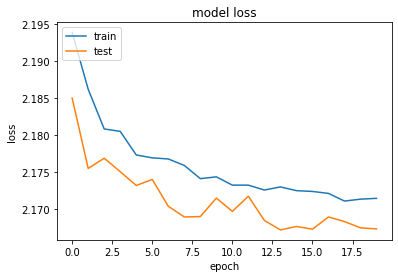

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()